## Finding the Best Dishes at a Restaurant

### Table of Contents

1. [Selecting a restaurant](#Selecting-Data)
2. [Selecting reviews that mention menu items]()
3. [Extracting sentence fragments]()
4. [Analyzing Sentiment Intensity]()

### Import libraries

In [129]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools as it
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from IPython.display import clear_output
from time import time 



### Set filepaths

In [2]:
# Directories
external_data_directory = os.path.join('..', 'data', 'external')
interim_data_directory = os.path.join('..', 'data', 'interim')
raw_data_directory = os.path.join('..', 'data', 'raw')

# Filepaths
review_csv_filepath = os.path.join(raw_data_directory, 
                                   'yelp_academic_dataset_review.csv')
restaurant_review_csv_filepath = os.path.join(interim_data_directory,
                                              'restaurant_review.csv')

mon_ami_gabi_filepath = os.path.join(interim_data_directory, 'mon_ami_gabi.csv')

### Get reviews for one restaurant by matching `business_id`

In [3]:
def get_restaurant_reviews(input_filepath, business_id):
    '''
    Selects reviews that match business_id and 
    returns them in a dataframe
    '''
    reviews = []
    
    # Open csv file
    with open(input_filepath, encoding = 'utf_8') as f_in:
        reader = csv.DictReader(f_in)
        columns = reader.fieldnames
        
        # Loop through all reviews
        for row in reader:
            if row['business_id'] == business_id:
                reviews.append(row)
                
    return pd.DataFrame(reviews)
 

In [4]:
def split_restaurant_reviews(input_filepath, output_filepath, business_id):
    '''
    Selects reviews that match business_id and 
    write to a new csv
    '''
    num_reviews = 0

    # Write to csv file
    with open(output_filepath, 'w', encoding = 'utf_8') as f_out:

        # Open csv file
        with open(input_filepath, encoding = 'utf_8') as f_in:
            # Instantiate reader
            reader = csv.DictReader(f_in)

            # Get column names
            columns = reader.fieldnames

            # Instantiate writer
            writer = csv.DictWriter(f_out, fieldnames = columns)

            # Write column names
            writer.writeheader()

            # Loop through all reviews
            for row in reader:            
                # Skip reviews that are not about a restaurant
                if row['business_id'] != business_id:
                    continue

                # Write row    
                writer.writerow(row)
                num_reviews += 1

    print (f'Found {num_reviews} reviews that match {business_id}.')


### Select reviews for one restaurant

In [44]:
%%time

mon_ami_gabi_id = '4JNXUYY8wbaaDmk3BPzlWw'
mon_ami_gabi = get_restaurant_reviews(restaurant_review_csv_filepath, mon_ami_gabi_id)


In [10]:
mon_ami_gabi = pd.read_csv('../data/interim/mon_ami_gabi.csv')

In [11]:
mon_ami_gabi.head()

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
0,I booked a table here for brunch and it did no...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
1,Came here for lunch after a long night of part...,0,0,cf9RrqHY9eQ9M53OPyXLtg,2012-01-20,4,4JNXUYY8wbaaDmk3BPzlWw,0,TVvTtXwPXsvrg2KJGoOUTg
2,Loved the fried goat cheese in tomato sauce al...,0,0,BvmhSQ6WFm2Jxu01G8OpdQ,2017-05-10,5,4JNXUYY8wbaaDmk3BPzlWw,0,etbAVunw-4kwr6VTRweZpA
3,"Love the outdoor atmosphere. Price was right, ...",0,0,IoKp9n1489XohTV_-EJ0IQ,2014-05-03,5,4JNXUYY8wbaaDmk3BPzlWw,0,vKXux2Xx3xcicTgYZoR0pg
4,Best steak in Vegas. Best mashed potatoes in V...,0,0,7YNmSq7Lb1zi4SUKXaSjfg,2014-06-04,5,4JNXUYY8wbaaDmk3BPzlWw,3,e3s1x4LLqfSkRTWDy_-Urg


### Load Menu

In [37]:
menu = pickle.load(open('../data/interim/mon_ami_gabi_menu.pk', 'rb'))
menu.shape

(75, 3)

In [38]:
menu.head()

,id,name,variations
0,onion_soup_au_gratin,onion soup au gratin,"[french onion soup, onion soup, french onion, ..."
1,steamed_artichoke,steamed artichoke,[steamed artichoke]
2,smoked_salmon,smoked salmon,[smoked salmon]
3,baked_goat_cheese,baked goat cheese,[goat cheese]
4,duck_confit,duck confit,[duck confit]


### Preprocess restaurant reviews

#### Lowercase, drop punctuations

In [12]:
import re

def multiple_replace(string, replace_dict):
    '''
    Performs multiple string replacements at once
    '''
    pattern = re.compile('|'.join([re.escape(k) for k in sorted(replace_dict, key = len, reverse = True)]), flags = re.DOTALL)
    return pattern.sub(lambda x : replace_dict[x.group(0)], string)                  

stop_chars = []
replace_dict = {','   : '', 
                ';'   : '',
                '('   : '', 
                ')'   : '', 
                '\n' : ' ', 
                '!'   : '.',
                '?'   : '.'}

In [13]:
mon_ami_gabi['text'] = mon_ami_gabi['text'].apply(lambda text: multiple_replace(text.lower(), replace_dict))


In [14]:
mon_ami_gabi['text'].head()

0    i booked a table here for brunch and it did no...
1    came here for lunch after a long night of part...
2    loved the fried goat cheese in tomato sauce al...
3    love the outdoor atmosphere. price was right s...
4    best steak in vegas. best mashed potatoes in v...
Name: text, dtype: object

### For each menu item, extract sentence fragments

In [15]:
def find_term(word_list, term):
    '''
    Arguments:
    word_list : List of strings
    term      : List or string of words to search for
    
    Return:
    results : List of tuples of `start` and `end` indices of term in word_list,
              where `start` is the index of the first character in `term` in word_list,
              and `end` is the index of the last character in `term` in word_list.
    '''    
    # Check if word_list is a string or list
    if type(word_list) is str:
        word_list = word_list.split()
    elif type(word_list) is not list:
        print('Error: word_list must be a list or string.')
        return None

    # Check if term is a string or list    
    if type(term) is str:
        term = term.split()
    elif type(term) is not list:
        print('Error: term must be a list or string.')
        return None

    results = []
    term_length = len(term)

    # Find indices of term[0] in sentence
    for ind in (i for i, word in enumerate(word_list) if word == term[0]):
        # Check if rest of the term matches
        if word_list[ind:ind + term_length] == term:
            results.append((ind, ind+term_length-1))

    return results

In [40]:
def get_chunks(word_list, term, n_before = 5, n_after = 5):
    '''
    Arguments:
    word_list : List or string of words
    term      : List or string of words to search for
    before    : Number of characters to span before term
    after     : Number of characters to span after term   
    
    Builds a list of chunks containing term
    
    Return:
    chunks : List of chunks
    
    '''
    # Check if word_list is a string or list
    if type(word_list) is str:
        word_list = word_list.split()
    elif type(word_list) is not list:
        print('Error: word_list must be a list or string.')
        return None
    
    # Check if term is a string or list    
    if type(term) is str:
        term = term.split()
    elif type(term) is not list:
        print('Error: term must be a list or string.')
        return None    
    
    indices = find_term(word_list, term)
#     print(indices)
    chunks = []

    for start, end in indices:
        before = n_before
        after = n_after
        
        # Check if start index is near the beginning of the word_list
        if start < n_before:
            before = start
        # Check if end index is near the end of the word_list
        if end > len(word_list) - n_after:
            after = len(word_list) - end
            
        chunks.append(' '.join(word_list[start-before : end+after+1]))
        
    return chunks



In [44]:
# Instantiate food chunks list
food_chunks = {food_id : [] for food_id in menu['id'] }

### Extract Sentence Fragments for each food item

In [16]:
from trie_search import TrieSearch

In [17]:
patterns = menu.loc[0]['variations']
trie = TrieSearch(patterns)

review_text = mon_ami_gabi[mon_ami_gabi['text'].str.contains('onion soup')]

In [31]:
review_text['text'].values[0]

"other than being right across the fountains of bellagio i'm not quite sure what the hype is about this place. we came here for brunch during peak hour but luckily had a reservation so ended up waiting only a few minutes.   our table ordered bordelaise steak frites with caramelized onion and red wine sauce chicken and mushroom crepe with kale and brie seafood crepe with scallops shrimp peas and cream onion soup and eggs benedict with canadian bacon and hollandaise sauce.   the steak frites and onion soup were the best things we ordered. steak frites came with a huge chunk of juicy steak and a side of crispy salted fries. onion soup was also a nice big portion but i can't say it stood out from other onion soups i've had. can't speak for the chicken and mushroom crepe since i didn't get to try it but everything else truthfully fell short of expectations. the seafood crepe not only lacked flavor but also was too creamy and heavy for my taste. the large pieces of shrimp and scallops saved 

In [36]:
for i, row in trie.search_all_patterns(review_text['text'].values[0]):
    print(i,row)

onion soup 403
onion soup 498
onion soup 628


In [18]:
review_text

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
18,other than being right across the fountains of...,1,2,uczUlWIWuO-KzoUiLhICNw,2015-02-10,2,4JNXUYY8wbaaDmk3BPzlWw,3,9zuYkm3k4_9KjE1PC8EPfg
36,french onion soup was watery with little taste...,0,0,185E0cpQpDRUO4JRGu3fXQ,2017-04-24,3,4JNXUYY8wbaaDmk3BPzlWw,0,EYiYLS0ZHDKGJSb1IKcpwg
38,where to begin. now our dining experience her...,0,0,QoY3L_d_axTcMn68pI8zxQ,2014-12-03,5,4JNXUYY8wbaaDmk3BPzlWw,1,mp3Xy-w2isyLjEN91xOeGQ
41,charming resturant that looks like it would be...,0,0,nth_q-GqOy_Ly8sxsREIwA,2010-12-04,4,4JNXUYY8wbaaDmk3BPzlWw,0,M4g64KUEia1qgcn-qNlYsw
64,this review is long overdue. i have been eat...,0,0,l0Lm7Dx69s6aH7a-5dwKDg,2010-07-11,5,4JNXUYY8wbaaDmk3BPzlWw,0,pQAUyBorkc1ZOxmV-uJ02w
80,this place gets an extra star just for their c...,0,0,-RR6sy7KqQ7J_x5hQxEUkA,2008-05-16,4,4JNXUYY8wbaaDmk3BPzlWw,2,0pYYhTaI10zY6YaF_v6y6Q
87,brunch with the family was out of this world. ...,0,0,EL1LCOPj40kQjLweA81Uww,2014-12-30,5,4JNXUYY8wbaaDmk3BPzlWw,0,k3zWNGw7yNdZSUcCnkAVLA
118,this place is amazing... food is superb and th...,0,0,d0RoeESPIt0dwtIPeZHuHA,2011-04-28,5,4JNXUYY8wbaaDmk3BPzlWw,0,RliOG8DxpFtxjfwBgYs2lg
148,by far my wife's favorite restaurant in town. ...,0,0,xXYvjebsbugZBvV7Dsjp-w,2011-07-02,5,4JNXUYY8wbaaDmk3BPzlWw,0,DWfos3PxcrkqAJoAZHEg3A
162,i love this place. went here for my mom's birt...,1,0,w5NsaqryEeRgxnNzJPJNCg,2014-01-12,5,4JNXUYY8wbaaDmk3BPzlWw,0,8zVYfHauMrKa-GiCJpDVKw


In [54]:
for pattern, start_idx in trie.search_all_patterns(review_text):
    print(pattern, start_idx)

In [ ]:
for _, item in menu.iterrows()

In [45]:
%%time

nrows = len(mon_ami_gabi)
# each review
for i, review in mon_ami_gabi.iterrows():
    clear_output(wait = True)
    print(f'Parsing {i+1}/{nrows} reviews')
    
    # each sentence
    for sentence in review['text'].split('.'):
        # each menu item
        for _, item in menu.iterrows():            
            # each food variation
            for variation in item['variations']:
                # get sentence fragment if sentence contains food item
                if variation in sentence:
                    chunks = get_chunks(sentence, variation, 7, 7)
                    food_chunks[item['id']].append(chunks)
                    break


Parsing 7968/7968 reviews
CPU times: user 8min 41s, sys: 10.5 s, total: 8min 51s
Wall time: 8min 54s


#### Drop any empty lists

In [46]:
for k,v in food_chunks.items():
    food_chunks[k] = [c for c in v if c]

In [47]:
def flatten(superlist): 
    '''
    Arguments: 
    superlist : A list of list of strings.

    Requirements: 
    Each element in superlist must be a list.
    
    Return:
    A flattened list of strings.

    ex: 
    flatten([['a'], ['b', 'c'], ['d', 'e', 'f']])
    >> ['a', 'b', 'c', 'd', 'e', 'f']
    '''    
    return [item \
            for sublist in superlist \
            for item in sublist]

#### Flatten list of lists of food chunks

In [550]:
# for food_id in food_chunks.keys():
#     food_chunks[food_id] = flatten(food_chunks[food_id])

In [48]:
# Flatten each food's list of chunks
food_chunks2 = {food_id : flatten(chunks) for food_id, chunks in food_chunks.items()}

### Predict sentiment score using `SentimentIntensityAnalyzer`

`SentimentIntensityAnalyzer` returns sentiment scores between `[0, 1]` for positive, negative, and neutral sentiments, `[-1, 1]` for the compound score.

In [49]:
def get_sentiments(docs):
    '''
    Returns a Dataframe of sentiment scores with columns:
    'compound', 'pos', 'neu', 'neg'
    
    For each doc, 'pos', 'neu', 'neg' scores add to 1.
    'compound' is an overall sentiment score of the doc.
    '''
    # Instantiate SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    sentiments = []

    # Generate sentiment score for each review
    for doc in docs:
        sentiment = sia.polarity_scores(doc)
        sentiments.append(sentiment)

    return pd.DataFrame(sentiments)

In [52]:
sentiments = []
onion_chunks = flatten(food_chunks['onion_soup_au_gratin'])

onion_sentiments = get_sentiments(onion_chunks)

In [53]:
type(onion_chunks)

list

### Predictions without dropping `compound=0`

In [54]:
food_sentiments = {}

for food_id, chunks in food_chunks2.items():
    # Run sentiment analyzer if item has chunks, otherwise default to 0
    if len(chunks) > 0:
        food_sentiments[food_id] = get_sentiments(chunks)['compound'].mean()
    else:
        food_sentiments[food_id] = np.nan

### Convert Sentiment Score to Stars

Transform continuous `[-1.0, 1.0]` range to discrete `[1, 5]`  
Metric: RMSE of `stars` and `mean_compound`.

In [120]:
def transform_to_stars(n, lower = -1, upper = 1):
    '''
    Transform n to a discrete value between 1 to 5, inclusive.
    '''
    if n < lower or n > upper:
        print(f'OutOfRangeError: Set n between [{lower},{upper}]')
        return None
    
    interval = np.round((upper - lower) / 9, 2)
    bins = [np.round(lower + i*interval, 2) for i in range(0,10)]
#     print(interval)
#     print(bins)
    
    # one star is the lowest rating, can't get 0.5 star
    n_categories = 9
    
    if n >= 0.5:
        return 5.0
    elif n >= 0.46:
        return 4.5
    elif n >= .42: 
        return 4.0
    elif n >= .38:
        return 3.5
    elif n >= .32:
        return 3.0
    elif n >= .28:        
        return 2.5
    elif n >= .24:
        return 2.0
    elif n >= .20:
        return 1.5
    else: 
        return 1.0
    
    for i in range(2,11):
        if bins[i-2] <= n <= bins[i-1]:
#             print(i)
            return i/2

    if n >= bins[-1]:
        return 5.0


In [58]:
def rescale_to_stars(scores, lower = -1, upper = 1):
    '''
    Rescale list of values to discrete values between 1 to 5, inclusive.

    Distributes the 5-star system to a uniform distribution of the input range.
    '''    
    interval = np.round((upper - lower) / 5, 2)
    bins = [np.round(lower + i*interval, 2) for i in range(0, 6)]

    return list(pd.cut(scores, bins = bins, labels = np.arange(1, 6, 1), include_lowest = True))


In [544]:
transform_to_stars(onion_score)

4.0

### Determine the overall sentiment score of each menu item

In [55]:
sentiment_df = pd.DataFrame(list(zip(food_sentiments.keys(), food_sentiments.values())), columns = ['food_id', 'sentiment_score'])


In [59]:
sentiment_df['stars_pred'] = sentiment_df['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df['mentions'] = sentiment_df['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

### Menu items that were never mentioned

In [61]:
sentiment_df[sentiment_df['mentions']==0]

,food_id,sentiment_score,stars_pred,mentions
20,root_vegetable_salad,NaN,NaN,0
33,tournedos_of_beef,NaN,NaN,0
46,sauteed_mushrooms,NaN,NaN,0
51,artichoke_and_spinach_benedict,NaN,NaN,0
52,salmon_and_hash_brown_benedict,NaN,NaN,0
66,applewood_smoked_bacon,NaN,NaN,0
67,sauteed_trout,NaN,NaN,0


### Distribution of sentiments

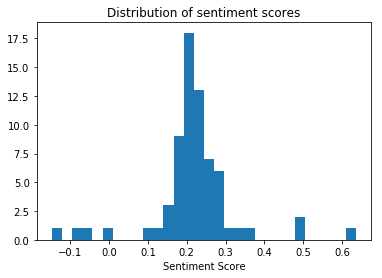

In [115]:
plt.title('Distribution of sentiment scores')
plt.xlabel('Sentiment Score')
plt.hist(sentiment_df['sentiment_score'].dropna(), bins = 30);


## Recommendations

### Show the best dishes

In [68]:
sentiment_df.nlargest(10, 'sentiment_score')


,food_id,sentiment_score,stars_pred,mentions
15,plats_du_jour,0.636900,4.5,1
65,gluten_free_toast,0.503800,4.0,7
54,avocado_toast,0.484000,4.0,3
70,chocolate_mousse,0.360857,4.0,80
9,spicy_salmon_tartare,0.346709,4.0,33
47,macaroni_gratin,0.306911,3.5,64
6,chicken_liver_mousse_pate,0.291230,3.5,114
4,duck_confit,0.283373,3.5,76
3,baked_goat_cheese,0.280490,3.5,324
57,cubano,0.278860,3.5,15


Looks like dishes with few mentions have an unfair advantage. Let's try ranking foods with more than 100 mentions.

In [95]:
sentiment_df[sentiment_df['mentions'] >= 100].nlargest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
41,frites,0.214937,3.5,2324
0,onion_soup_au_gratin,0.271198,3.5,987
36,salmon,0.250284,3.5,873
12,scallops_gratinees,0.240067,3.5,637
30,filet_mignon,0.222414,3.5,550
50,classic_eggs_benedict,0.273474,3.5,538
26,prime_steak_frites,0.205338,3.5,532
13,mussels_mariniere,0.190327,3.5,435
53,french_toast,0.260120,3.5,360
3,baked_goat_cheese,0.280490,3.5,324


Dishes that are rarely mentioned 

In [94]:
sentiment_df[sentiment_df['mentions'] <= 10].nlargest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
10,oysters_du_jour,0.125330,3.5,10
1,steamed_artichoke,0.252537,3.5,8
14,gabis_fish_and_frites,-0.054543,3.0,7
65,gluten_free_toast,0.503800,4.0,7
59,banana_foster_waffle,-0.088080,3.0,5
54,avocado_toast,0.484000,4.0,3
16,poisson_du_jour,0.000000,3.0,2
15,plats_du_jour,0.636900,4.5,1
38,casareccia_pasta,-0.148000,2.5,2


### Show the worst dishes

In [93]:
sentiment_df.nsmallest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
38,casareccia_pasta,-0.148000,2.5,2
16,poisson_du_jour,0.000000,3.0,2
59,banana_foster_waffle,-0.088080,3.0,5
14,gabis_fish_and_frites,-0.054543,3.0,7
1,steamed_artichoke,0.252537,3.5,8
10,oysters_du_jour,0.125330,3.5,10
57,cubano,0.278860,3.5,15
73,gala_apple_tarte_tatin,0.268800,3.5,17
72,sorbet_du_jour,0.244368,3.5,19
18,endive_salad,0.257970,3.5,20


Now only using dishes with more than 100 mentions:

In [92]:
sentiment_df[sentiment_df['mentions'] >= 100].nsmallest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
42,cauliflower_puree,0.243590,3.5,100
74,maple_bread_pudding,0.209417,3.5,111
6,chicken_liver_mousse_pate,0.291230,3.5,114
8,chilled_seafood_platter,0.235148,3.5,118
21,classique,0.240794,3.5,122
71,vanilla_bean_creme_brulee,0.198299,3.5,127
56,prime_steak_sandwich,0.187556,3.5,139
58,waffle,0.178049,3.5,139
61,seafood_crepe,0.229868,3.5,139
29,hanger_steak,0.233625,3.5,147


In [64]:
sentiment_df.to_csv('../data/predictions/sentiment_df.csv')

### Predictions after dropping `compound=0`

In [82]:
food_sentiments2 = {}

for food_id, chunks in food_chunks2.items():
    # Run sentiment analyzer if item has chunks, otherwise default to 0
    if len(chunks) > 0:
        sentiment_score = get_sentiments(chunks)['compound']
        food_sentiments2[food_id] = sentiment_score[sentiment_score != 0].mean()
    else:
        food_sentiments2[food_id] = np.nan

In [83]:
sentiment_df2 = pd.DataFrame(list(zip(food_sentiments2.keys(), food_sentiments2.values())), columns = ['food_id', 'sentiment_score'])


In [84]:
sentiment_df2['stars_pred'] = sentiment_df2['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df2['mentions'] = sentiment_df2['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

#### With custom transformations

In [121]:
sentiment_df3 = pd.DataFrame(list(zip(food_sentiments2.keys(), food_sentiments2.values())), columns = ['food_id', 'sentiment_score'])

sentiment_df3['stars_pred'] = sentiment_df3['sentiment_score'].apply(lambda score : transform_to_stars(score))
sentiment_df3['mentions'] = sentiment_df3['food_id'].apply(lambda food_id : len(food_chunks[food_id]))

Best dishes with over 200 mentions

In [128]:
sentiment_df3[sentiment_df3['mentions'] > 200].sort_values(by = ['stars_pred', 'mentions'], ascending = [False, False])


,food_id,sentiment_score,stars_pred,mentions
36,salmon,0.473217,4.5,873
50,classic_eggs_benedict,0.473387,4.5,538
0,onion_soup_au_gratin,0.426657,4.0,987
12,scallops_gratinees,0.421878,4.0,637
30,filet_mignon,0.433164,4.0,550
53,french_toast,0.459178,4.0,360
3,baked_goat_cheese,0.455625,4.0,324
63,quiche,0.451370,4.0,293
26,prime_steak_frites,0.395956,3.5,532
13,mussels_mariniere,0.388301,3.5,435


In [130]:
sentiment_df3[sentiment_df3['food_id'] == 'onion_soup_au_gratin']

,food_id,sentiment_score,stars_pred,mentions
0,onion_soup_au_gratin,0.426657,4.0,987


Worst dishes with over 200 mentions

In [133]:
sentiment_df3[sentiment_df3['mentions'] < 10].dropna().sort_values(by = ['stars_pred', 'mentions'], ascending = [False, False])


,food_id,sentiment_score,stars_pred,mentions
65,gluten_free_toast,0.587767,5.0,7
15,plats_du_jour,0.636900,5.0,1
54,avocado_toast,0.484000,4.5,3
1,steamed_artichoke,0.404060,3.5,8
14,gabis_fish_and_frites,-0.381800,1.0,7
59,banana_foster_waffle,-0.440400,1.0,5
38,casareccia_pasta,-0.296000,1.0,2


### Distribution of sentiment scores

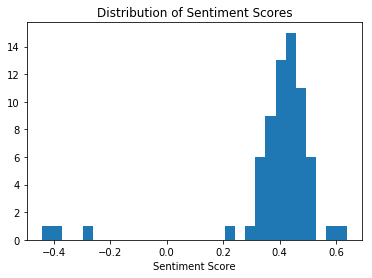

In [113]:
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.hist(sentiment_df2['sentiment_score'].dropna(), bins = 30);

### Show the best dishes

In [91]:
sentiment_df2.nlargest(10, ['stars_pred', 'mentions'])


,food_id,sentiment_score,stars_pred,mentions
41,frites,0.373482,4.0,2324
0,onion_soup_au_gratin,0.426657,4.0,987
36,salmon,0.473217,4.0,873
12,scallops_gratinees,0.421878,4.0,637
30,filet_mignon,0.433164,4.0,550
50,classic_eggs_benedict,0.473387,4.0,538
26,prime_steak_frites,0.395956,4.0,532
13,mussels_mariniere,0.388301,4.0,435
53,french_toast,0.459178,4.0,360
3,baked_goat_cheese,0.455625,4.0,324


Using dishes with more than 100 reviews:

In [90]:
sentiment_df2[sentiment_df2['mentions'] >= 100].nlargest(10, ['stars_pred', 'mentions'])

,food_id,sentiment_score,stars_pred,mentions
41,frites,0.373482,4.0,2324
0,onion_soup_au_gratin,0.426657,4.0,987
36,salmon,0.473217,4.0,873
12,scallops_gratinees,0.421878,4.0,637
30,filet_mignon,0.433164,4.0,550
50,classic_eggs_benedict,0.473387,4.0,538
26,prime_steak_frites,0.395956,4.0,532
13,mussels_mariniere,0.388301,4.0,435
53,french_toast,0.459178,4.0,360
3,baked_goat_cheese,0.455625,4.0,324


### Show the worst dishes

In [612]:
menu_df2.nsmallest(10, 'sentiment_score')

,food_id,sentiment_score,stars_pred,mentions
71,banana_foster_waffle,-0.440400,2.0,5
16,gabis_fish_and_frites,-0.381800,2.0,7
43,casareccia_pasta,-0.296000,2.5,2
12,oysters_du_jour,0.208883,3.5,10
49,brussels_sprouts,0.305337,3.5,62
84,housemade_english_muffin,0.332280,4.0,48
86,vanilla_bean_creme_brulee,0.333041,4.0,127
42,classic_skate_wing,0.337419,4.0,56
6,country_pate,0.339022,4.0,56
50,french_green_beans,0.342860,4.0,79


In [101]:
sentiment_df2.sort_values(by = ['sentiment_score', 'mentions'], ascending = [True, False]).head(10)

,food_id,sentiment_score,stars_pred,mentions
59,banana_foster_waffle,-0.440400,2.0,5
14,gabis_fish_and_frites,-0.381800,2.0,7
38,casareccia_pasta,-0.296000,2.5,2
10,oysters_du_jour,0.208883,3.5,10
43,brussels_sprouts,0.305337,3.5,62
69,housemade_english_muffin,0.332280,4.0,48
71,vanilla_bean_creme_brulee,0.333041,4.0,127
37,classic_skate_wing,0.337419,4.0,56
5,country_pate,0.339022,4.0,56
44,french_green_beans,0.342860,4.0,79


In [389]:
food_item['variations'].values[0]

['french onion soup', 'onion soup', 'french onion', 'au gratin']

In [355]:
# one food item
item_id = 'onion_soup_au_gratin'
sentences = []

mon_ami_gabi[mon_ami_gabi['text'].str.contains('|'.join(menu.loc[menu['id']==item_id,'variations'].values[0]))]


# item_mask = any([mon_ami_gabi['text'].str.contains(variation) 
#                 for variation in menu.loc[menu['id'] == item_name,'variations'].values[0]])
    

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
18,other than being right across the fountains of...,1,2,uczUlWIWuO-KzoUiLhICNw,2015-02-10,2,4JNXUYY8wbaaDmk3BPzlWw,3,9zuYkm3k4_9KjE1PC8EPfg
36,french onion soup was watery with little taste...,0,0,185E0cpQpDRUO4JRGu3fXQ,2017-04-24,3,4JNXUYY8wbaaDmk3BPzlWw,0,EYiYLS0ZHDKGJSb1IKcpwg
38,where to begin! now our dining experience her...,0,0,QoY3L_d_axTcMn68pI8zxQ,2014-12-03,5,4JNXUYY8wbaaDmk3BPzlWw,1,mp3Xy-w2isyLjEN91xOeGQ
41,charming resturant that looks like it would be...,0,0,nth_q-GqOy_Ly8sxsREIwA,2010-12-04,4,4JNXUYY8wbaaDmk3BPzlWw,0,M4g64KUEia1qgcn-qNlYsw
64,this review is long overdue! \n\ni have been e...,0,0,l0Lm7Dx69s6aH7a-5dwKDg,2010-07-11,5,4JNXUYY8wbaaDmk3BPzlWw,0,pQAUyBorkc1ZOxmV-uJ02w
80,this place gets an extra star just for their c...,0,0,-RR6sy7KqQ7J_x5hQxEUkA,2008-05-16,4,4JNXUYY8wbaaDmk3BPzlWw,2,0pYYhTaI10zY6YaF_v6y6Q
87,brunch with the family was out of this world. ...,0,0,EL1LCOPj40kQjLweA81Uww,2014-12-30,5,4JNXUYY8wbaaDmk3BPzlWw,0,k3zWNGw7yNdZSUcCnkAVLA
118,this place is amazing!!! food is superb and th...,0,0,d0RoeESPIt0dwtIPeZHuHA,2011-04-28,5,4JNXUYY8wbaaDmk3BPzlWw,0,RliOG8DxpFtxjfwBgYs2lg
148,by far my wife's favorite restaurant in town. ...,0,0,xXYvjebsbugZBvV7Dsjp-w,2011-07-02,5,4JNXUYY8wbaaDmk3BPzlWw,0,DWfos3PxcrkqAJoAZHEg3A
162,i love this place! went here for my mom's birt...,1,0,w5NsaqryEeRgxnNzJPJNCg,2014-01-12,5,4JNXUYY8wbaaDmk3BPzlWw,0,8zVYfHauMrKa-GiCJpDVKw


In [350]:
any([True, False])

True

In [329]:
mon_ami_gabi[mon_ami_gabi['text'].str.contains('onion soup')].shape

(868, 9)

### Save reviews that mention onion soup to a csv

In [196]:
food_id = 'onion_soup'
food = 'onion soup'

food_filepath = os.path.join(interim_directory, 'food', f'{food_id}.csv')

split_reviews_by_food(mon_ami_gabi_filepath, food_filepath, food)


Found 868 reviews that mention onion soup.


In [197]:
food_filepath

'../data/interim/food/onion_soup.csv'

### Save reviews to separate csv for each food item

In [200]:
for i,row in menu.iterrows():
    food_filepath = os.path.join(interim_directory, 'food', f'{row["id"]}.csv')
    
    for query in row['variations']:
        split_reviews_by_food(mon_ami_gabi_filepath, food_filepath, query)
                                 

Found 8 reviews that mention steamed artichoke.
Found 1 reviews that mention wild escargot de bourgogne.
Found 604 reviews that mention escargot.
Found 27 reviews that mention wild escargot.
Found 43 reviews that mention bourgogne.
Found 164 reviews that mention smoked salmon.
Found 286 reviews that mention goat cheese.
Found 74 reviews that mention duck confit.
Found 54 reviews that mention country pate.
Found 23 reviews that mention chicken liver mousse pate.
Found 106 reviews that mention chicken liver.
Found 28 reviews that mention mousse pate.
Found 24 reviews that mention steak tartare.
Found 0 reviews that mention charcuterie and cheese platter.
Found 11 reviews that mention charcuterie.
Found 14 reviews that mention cheese platter.
Found 13 reviews that mention chilled seafood.
Found 105 reviews that mention seafood platter.
Found 2 reviews that mention spicy salmon.
Found 30 reviews that mention salmon tartare.
Found 9 reviews that mention oysters du jour.
Found 60 reviews tha

In [201]:
food_filepath = os.path.join(interim_directory, 'food', 'filet_mignon.csv')

food_reviews = pd.read_csv(food_filepath)

In [202]:
food_reviews.head()

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
0,Best steak in Vegas. Best mashed potatoes in V...,0,0,7YNmSq7Lb1zi4SUKXaSjfg,2014-06-04,5,4JNXUYY8wbaaDmk3BPzlWw,3,e3s1x4LLqfSkRTWDy_-Urg
1,Ate here for our first anniversary. Wanted a p...,0,0,COmPW1Ym7K0i2QDijgbMkw,2014-04-23,5,4JNXUYY8wbaaDmk3BPzlWw,0,9I-Z_S-vB0sTdrMyGQSVVQ
2,"Service was great, outdoor patio ist pretty ni...",0,0,g_6xExvgS8sA7G3XjWoM8Q,2014-05-19,2,4JNXUYY8wbaaDmk3BPzlWw,0,IfxWXdnf3djmeGYTjiJeQg
3,"Mon Ami Gabi was good, but not amazing. I went...",0,0,8Cs8iruNSMQy3EwBPRSqzw,2011-11-27,4,4JNXUYY8wbaaDmk3BPzlWw,0,lXCZe0xAd7DwV5aARJu92g
4,This place gets an extra star just for their c...,0,0,-RR6sy7KqQ7J_x5hQxEUkA,2008-05-16,4,4JNXUYY8wbaaDmk3BPzlWw,2,0pYYhTaI10zY6YaF_v6y6Q


### NLP with spaCy

In [72]:
# Instantiate spacy parser
nlp = spacy.load('en')

In [246]:
mon_ami_gabi = pd.read_csv(mon_ami_gabi_filepath)

In [247]:
mon_ami_gabi.head()

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
0,I booked a table here for brunch and it did no...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
1,Came here for lunch after a long night of part...,0,0,cf9RrqHY9eQ9M53OPyXLtg,2012-01-20,4,4JNXUYY8wbaaDmk3BPzlWw,0,TVvTtXwPXsvrg2KJGoOUTg
2,Loved the fried goat cheese in tomato sauce al...,0,0,BvmhSQ6WFm2Jxu01G8OpdQ,2017-05-10,5,4JNXUYY8wbaaDmk3BPzlWw,0,etbAVunw-4kwr6VTRweZpA
3,"Love the outdoor atmosphere. Price was right, ...",0,0,IoKp9n1489XohTV_-EJ0IQ,2014-05-03,5,4JNXUYY8wbaaDmk3BPzlWw,0,vKXux2Xx3xcicTgYZoR0pg
4,Best steak in Vegas. Best mashed potatoes in V...,0,0,7YNmSq7Lb1zi4SUKXaSjfg,2014-06-04,5,4JNXUYY8wbaaDmk3BPzlWw,3,e3s1x4LLqfSkRTWDy_-Urg


'../data/interim/mon_ami_gabi.csv'

In [82]:
%%time

parsed_review = nlp(sample_review)

CPU times: user 114 ms, sys: 13.5 ms, total: 128 ms
Wall time: 40.9 ms


In [83]:
print(parsed_review)

Food is pretty good, not gonna lie. BUT you have to make sacrifices if you choose to eat there. It literally takes an hour to an hour and a half to deliver food. Seriously. EVERY SINGLE TIME. Doesnt matter if we order at 8am, 10am or 1pm. Never fails, they take F-O-R-E-V-E-R. If you dont get what you ordered or you are upset by them delivering your breakfast around LUNCH time, be ready to have the owner talk down to you and be a total bitch to you for i dont know, just wanting what you pay for?! Its over priced. But its decently tasteful food. Takes forever. Owners a witch. And i'm pretty sure that they continuing forget to pack my extra ranch just to piss me off. End Rant. PS- I've never gone in there to eat because i frankly, i'd rather tip the nice delivery driver then the ignorant imbeciles that work in the dining area. PPS- My hot chocolate today was cold. They should call it Cold Chocolate. Or start caring if their hot chocolate is hot. One of the two would be great!



### Phrase Modeling

In [259]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phraser

In [90]:
def punct_space(token):
    '''
    Helper function to filter tokens that are 
    punctuation or whitespace
    '''
    return token.is_punct or token.is_space

def line_review(filename):
    with open(filename, encoding = 'utf_8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            yield row['text']
            
def lemmatize(doc):
    parsed_doc = nlp(doc)
    lemmatized_doc = ' '.join([token.lemma_ for token in parsed_doc
                               if not punct_space(token)])
    return lemmatized_doc
          



In [74]:
text = mon_ami_gabi['text'][0]
parsed_text = nlp(text)
# mon_ami_gabi['parsed_text'] = mon_ami_gabi['text'].apply(lambda text: nlp(text))
# for sentence in parsed_review.sents:
#             lemmatized_sentence = ' '.join([token.lemma_ for token in sentence
#                                            if not punct_space(token)])
#             print(lemmatized_sentence)

In [75]:
lemmas = [token.lemma_ for token in parsed_text.sents]

In [79]:
lemmatized_doc = lemmatize(text)

In [80]:
lemmatized_doc

'-PRON- book a table here for brunch and -PRON- do not disappoint -PRON- be a great experience and more relaxed -PRON- feel that the pricy dinner menu would of be with the same outdoor table overlook the bellagio fountain and the paris hotel egg benedict for -PRON- be fab and some other good option on the menu -PRON- tell -PRON- -PRON- be celebrate a birthday and get a chocolate cake with a candle bring out which -PRON- be pleased to find be not include on -PRON- bill at the end'

In [97]:
%%time
n_reviews = len(mon_ami_gabi['text'])
for i,text in enumerate(mon_ami_gabi['text']):
    lemma_text = lemmatize(text)
    clear_output(wait = True)
    print(f'{i+1}/{n_reviews}')
#     print(lemmatized_doc)

375/7968


KeyboardInterrupt: 

In [81]:
%%time

mon_ami_gabi['lemma_text'] = mon_ami_gabi['text'].apply(lambda text: lemmatize(text))

KeyboardInterrupt: 

In [ ]:
mon_ami_gabi[['text','lemma_text']].head()

In [ ]:
mon_ami_gabi.head()

In [262]:
bigram_model = Phrases(lemmas)

In [263]:
bigram_model

In [258]:
bigram_sents = [bigram_model[sent] for sent in lemmas]

/anaconda3/envs/dsi/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Lemmatize Corpus

In [99]:
unigram_sentences_filepath = os.path.join(interim_data_directory, 'unigram_sentences_all.csv')
unigram_sentences_filepath 

'../data/interim/unigram_sentences_all.csv'

In [100]:
%%time

# Write to csv
with open(unigram_sentences_filepath, 'w', encoding = 'utf_8') as f_out:
    # Read csv
    with open(mon_ami_gabi_filepath, encoding = 'utf_8') as f_in:
        reader = csv.DictReader(f_in)
        columns = reader.fieldnames
        
        writer = csv.DictWriter(f_out, fieldnames = columns)
        writer.writeheader()
        
        for row in reader:
            parsed_review = nlp(row['text'])
#             print(parsed_review)
            for sentence in parsed_review.sents:
                new_row = row.copy()
                new_row['text'] = ' '.join([token.lemma_ for token in sentence
                                            if not punct_space(token)])
#                 print(lemmatized_sentence)
                writer.writerow(new_row)


KeyboardInterrupt: 

In [101]:
unigram_sentences = pd.read_csv(unigram_sentences_filepath)

In [102]:
unigram_sentences.head()

,text,cool,funny,review_id,date,stars,business_id,useful,user_id
0,-PRON- book a table here for brunch and -PRON-...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
1,-PRON- feel that the pricy dinner menu would o...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
2,egg benedict for -PRON- be fab and some other ...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
3,-PRON- tell -PRON- -PRON- be celebrate a birth...,0,0,wl8BO_I-is-JaMwMW5c_gQ,2012-06-10,4,4JNXUYY8wbaaDmk3BPzlWw,0,fo4mpUqgXL2mJqALc9AvbA
4,come here for lunch after a long night of part...,0,0,cf9RrqHY9eQ9M53OPyXLtg,2012-01-20,4,4JNXUYY8wbaaDmk3BPzlWw,0,TVvTtXwPXsvrg2KJGoOUTg
